## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
import math
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
%matplotlib inline


В этом примере мы попробуем предсказать итоговую оценку участинка только на основе **его действий**

In [2]:
df_train = pd.read_csv("train.csv")
df_user = pd.read_csv("user_decision.csv")

## Рассмотрим датасет по ближе

In [3]:
df_train.shape


(680, 5)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   680 non-null    int64  
 1   Analytical thinking  680 non-null    float64
 2   Systemic thinking    680 non-null    float64
 3   Adaptability         680 non-null    float64
 4   Focus                680 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 26.7 KB


In [5]:
df_train.head(30)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0
5,10908,4.0,4.0,5.0,5.0
6,10378,4.0,5.0,5.0,4.0
7,10220,5.0,4.0,5.0,5.0
8,10612,5.0,4.0,4.0,5.0
9,10776,4.0,4.0,5.0,5.0


In [6]:
df_user.shape

(60228, 3)

In [7]:
df_user.head(3)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420


In [8]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60228 entries, 0 to 60227
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      60228 non-null  int64
 1   period       60228 non-null  int64
 2   decision_id  60228 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


Заметим что в есть категория где пользватель совершал больше действий

In [9]:
df_user.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение периода')

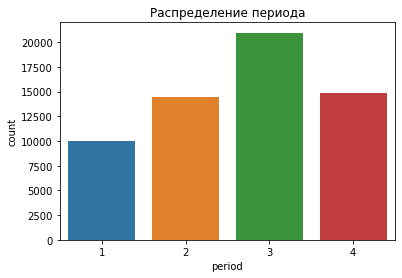

In [10]:
sns.countplot(x = "period" , data  = df_user).set_title('Распределение периода')

Text(0.5, 1.0, 'Распределение действий')

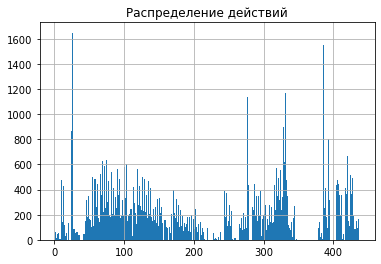

In [11]:
df_user["decision_id"].hist(bins = 300).set_title('Распределение действий')

### Добавим новых значений

Узнаем частоту команд участника в каждом периоде

In [12]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in df_train.id.values)]

In [13]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [14]:
df_decision_count.head(5)

decision_id
user_id period             
10001   1                29
        2                23
        3                39
        4                15
10003   1                21

In [15]:
for id in df_train.id.values:
  for period in range(1,5):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [16]:
df_train.head(3)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0


In [17]:
df_train=df_train.fillna(df_train.mean())

In [18]:
df_train.isna().sum()

id                     0
Analytical thinking    0
Systemic thinking      0
Adaptability           0
Focus                  0
period_1               0
period_2               0
period_3               0
period_4               0
dtype: int64

In [19]:
df_train['sum']=df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4']
df_train['quad']=df_train['period_1'] * df_train['period_1'] + df_train['period_2'] * df_train['period_2'] + df_train['period_3'] * df_train['period_3'] + df_train['period_4'] * df_train['period_4']
df_train['medan']=(df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4'])/4
df_train['sqr_median']=np.sqrt(df_train['medan'])
df_train['sqr_sum']=np.sqrt(df_train['sum'])

In [20]:
df_train

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,sum,quad,medan,sqr_median,sqr_sum
0,10884,4.0,4.0,4.0,4.0,7.000000,14.000000,28.0,10.0,59.000000,1129.000000,14.750000,3.840573,7.681146
1,10106,5.0,4.0,5.0,5.0,21.000000,21.000000,12.0,8.0,62.000000,1090.000000,15.500000,3.937004,7.874008
2,10438,6.0,5.0,5.0,5.0,62.000000,45.000000,63.0,38.0,208.000000,11282.000000,52.000000,7.211103,14.422205
3,10130,5.0,4.0,5.0,5.0,26.000000,28.000000,34.0,66.0,154.000000,6972.000000,38.500000,6.204837,12.409674
4,10667,4.0,5.0,5.0,5.0,58.000000,70.000000,194.0,35.0,357.000000,47125.000000,89.250000,9.447222,18.894444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,10563,5.0,4.0,5.0,4.0,10.000000,2.000000,14.0,4.0,30.000000,316.000000,7.500000,2.738613,5.477226
676,10386,5.0,4.0,5.0,5.0,1.000000,14.000000,24.0,1.0,40.000000,774.000000,10.000000,3.162278,6.324555
677,10675,5.0,4.0,5.0,4.0,4.000000,17.000000,23.0,12.0,56.000000,978.000000,14.000000,3.741657,7.483315
678,10366,4.0,4.0,4.0,4.0,10.000000,44.000000,45.0,38.0,137.000000,5505.000000,34.250000,5.852350,11.704700


In [21]:
df_train=df_train.append(df_train)

/tmp/ipykernel_87307/1467900330.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_train)


In [22]:

df_train['Focus'].value_counts()

4.0    800
5.0    488
3.0     58
6.0      6
1.0      6
2.0      2
Name: Focus, dtype: int64


focus1=df_train.query("Adaptability==2").head()
focus2=df_train.query("Adaptability==1").head()
focus3=df_train.query("Adaptability==6").head()
focus4=df_train.query("Adaptability==3").head()
for i in range(1,10):
    df_train=df_train.append(focus1, ignore_index=True)
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)
    df_train=df_train.append(focus4, ignore_index=True)

In [23]:
df_train['Adaptability'].value_counts()

5.0    636
4.0    616
3.0     72
6.0     30
1.0      4
2.0      2
Name: Adaptability, dtype: int64

In [24]:
df_train=df_train.query('Adaptability!=2')
df_train=df_train.query('Focus!=2')

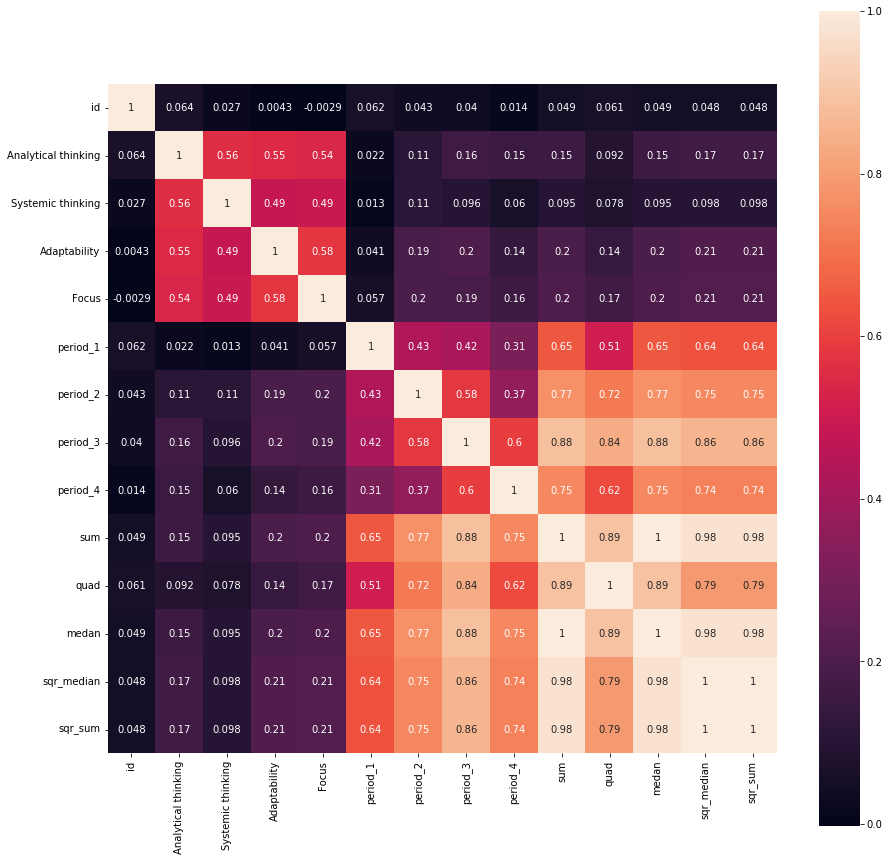

In [25]:
plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(df_train.corr(), square = True, annot=True)

In [26]:
df_train

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,sum,quad,medan,sqr_median,sqr_sum
0,10884,4.0,4.0,4.0,4.0,7.000000,14.000000,28.0,10.0,59.000000,1129.000000,14.750000,3.840573,7.681146
1,10106,5.0,4.0,5.0,5.0,21.000000,21.000000,12.0,8.0,62.000000,1090.000000,15.500000,3.937004,7.874008
2,10438,6.0,5.0,5.0,5.0,62.000000,45.000000,63.0,38.0,208.000000,11282.000000,52.000000,7.211103,14.422205
3,10130,5.0,4.0,5.0,5.0,26.000000,28.000000,34.0,66.0,154.000000,6972.000000,38.500000,6.204837,12.409674
4,10667,4.0,5.0,5.0,5.0,58.000000,70.000000,194.0,35.0,357.000000,47125.000000,89.250000,9.447222,18.894444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,10563,5.0,4.0,5.0,4.0,10.000000,2.000000,14.0,4.0,30.000000,316.000000,7.500000,2.738613,5.477226
676,10386,5.0,4.0,5.0,5.0,1.000000,14.000000,24.0,1.0,40.000000,774.000000,10.000000,3.162278,6.324555
677,10675,5.0,4.0,5.0,4.0,4.000000,17.000000,23.0,12.0,56.000000,978.000000,14.000000,3.741657,7.483315
678,10366,4.0,4.0,4.0,4.0,10.000000,44.000000,45.0,38.0,137.000000,5505.000000,34.250000,5.852350,11.704700


In [27]:
df_train['Focus'].value_counts()

4.0    800
5.0    488
3.0     58
6.0      6
1.0      6
Name: Focus, dtype: int64

In [28]:
df_train['Adaptability'].value_counts()

5.0    636
4.0    616
3.0     72
6.0     30
1.0      4
Name: Adaptability, dtype: int64

focus2=df_train.query("Adaptability==1").head(25)
for i in range(1,10):
    df_train=df_train.append(focus2, ignore_index=True)
    

focus2=df_train.query("Focus==1").head(25)
focus3=df_train.query("Focus==6").head(25)
for i in range(1,5):
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)

## Выделим выборки

In [29]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Analytical thinking']
sm = SMOTE(random_state=42)

X, y = sm.fit_resample(X, y)

In [30]:
X.shape

(4160, 9)

In [31]:
X

,period_1,period_2,period_3,period_4,sum,quad,medan,sqr_median,sqr_sum
0,7.000000,14.000000,28.000000,10.000000,59.000000,1129.000000,14.750000,3.840573,7.681146
1,21.000000,21.000000,12.000000,8.000000,62.000000,1090.000000,15.500000,3.937004,7.874008
2,62.000000,45.000000,63.000000,38.000000,208.000000,11282.000000,52.000000,7.211103,14.422205
3,26.000000,28.000000,34.000000,66.000000,154.000000,6972.000000,38.500000,6.204837,12.409674
4,58.000000,70.000000,194.000000,35.000000,357.000000,47125.000000,89.250000,9.447222,18.894444
...,...,...,...,...,...,...,...,...,...
4155,47.820589,52.352287,65.625817,33.273530,199.072222,10698.543481,49.768056,7.053047,14.106093
4156,32.872861,49.782399,43.183381,29.000000,154.838641,6554.155019,38.709660,6.205305,12.410609
4157,12.953875,8.748138,45.503723,9.816908,77.022644,2462.265850,19.255661,4.387287,8.774573
4158,13.644308,32.923004,14.509683,7.865376,68.942371,1732.479456,17.235593,4.146234,8.292468


In [32]:
X.isna().sum()

period_1      0
period_2      0
period_3      0
period_4      0
sum           0
quad          0
medan         0
sqr_median    0
sqr_sum       0
dtype: int64

In [33]:
y

0       4.0
1       5.0
2       6.0
3       5.0
4       4.0
       ... 
4155    6.0
4156    6.0
4157    6.0
4158    6.0
4159    6.0
Name: Analytical thinking, Length: 4160, dtype: float64

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение модели

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
rf_model_Analytical_thinking = GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Analytical_thinking.fit(X_train, y_train)

GaussianNB()

## Оценка точности

In [36]:
pred = rf_model_Analytical_thinking.predict(X_test)

In [37]:
pred

array([4., 1., 1., 3., 5., 6., 1., 1., 1., 5., 1., 1., 1., 1., 5., 5., 5.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 6., 3., 1., 1., 5., 1., 1., 6.,
       1., 3., 5., 1., 1., 6., 1., 1., 1., 1., 5., 1., 1., 1., 1., 1., 5.,
       1., 1., 3., 1., 1., 1., 1., 1., 5., 1., 3., 1., 1., 6., 1., 1., 1.,
       1., 6., 1., 4., 1., 5., 1., 1., 1., 1., 1., 1., 1., 1., 1., 6., 1.,
       3., 3., 1., 1., 5., 4., 1., 1., 1., 1., 3., 5., 1., 6., 1., 3., 1.,
       1., 5., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 5., 1., 6., 5., 1.,
       1., 1., 1., 1., 6., 1., 1., 1., 1., 1., 6., 1., 1., 1., 3., 1., 1.,
       5., 5., 1., 1., 1., 5., 1., 6., 6., 1., 1., 1., 1., 1., 1., 3., 1.,
       5., 6., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 5., 3., 5.,
       1., 1., 1., 1., 5., 5., 1., 1., 1., 3., 1., 5., 1., 3., 5., 1., 5.,
       1., 5., 5., 5., 1., 1., 5., 5., 1., 6., 1., 1., 1., 1., 1., 6., 1.,
       1., 1., 3., 4., 1., 5., 6., 1., 1., 1., 5., 6., 1., 1., 5., 1., 1.,
       1., 1., 1., 1., 1.

In [38]:

print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.25      0.85      0.39       161
         3.0       0.23      0.08      0.12       143
         4.0       0.00      0.00      0.00       189
         5.0       0.44      0.33      0.37       178
         6.0       0.13      0.07      0.09       161

    accuracy                           0.26       832
   macro avg       0.21      0.27      0.19       832
weighted avg       0.21      0.26      0.19       832



In [39]:
X = df_train.drop(['Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Systemic thinking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_Systemic_thinking =  GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Systemic_thinking.fit(X_train, y_train)
pred = rf_model_Systemic_thinking.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.50      1.00      0.67         1
         3.0       0.80      0.27      0.40        15
         4.0       0.80      0.88      0.84       204
         5.0       0.27      0.15      0.19        46
         6.0       0.25      0.67      0.36         6

    accuracy                           0.72       272
   macro avg       0.52      0.59      0.49       272
weighted avg       0.70      0.72      0.69       272



param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

In [40]:
X = df_train.drop(['Adaptability', 'Focus','id'], axis = 1)
y = df_train['Adaptability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_Adaptability =  GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Adaptability.fit(X_train, y_train)
pred = rf_model_Adaptability.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         3.0       0.27      0.27      0.27        11
         4.0       0.58      0.84      0.69       131
         5.0       0.69      0.35      0.47       119
         6.0       0.22      0.20      0.21        10

    accuracy                           0.58       272
   macro avg       0.55      0.53      0.53       272
weighted avg       0.60      0.58      0.56       272



param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

In [41]:
X = df_train.drop(['Focus','id'], axis = 1)
y = df_train['Focus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_Focus =  GaussianNB() # Ваш код здесь
# обучим модель случайного леса
rf_model_Focus.fit(X_train, y_train)
pred = rf_model_Focus.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         3.0       0.23      0.46      0.31        13
         4.0       0.64      0.79      0.71       154
         5.0       0.77      0.42      0.54       103
         6.0       1.00      1.00      1.00         1

    accuracy                           0.63       272
   macro avg       0.73      0.73      0.71       272
weighted avg       0.67      0.63      0.63       272



param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(var_smoothing=0.0001519911082952933), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

In [42]:
# Предикт.

In [43]:
datapre=pd.read_csv('sample_solution.csv')

In [44]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [45]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in datapre.id.values)]

In [46]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [47]:
df_decision_count.head(5)

decision_id
user_id period             
10002   2                 9
        3                25
        4                22
10005   1                14
        2                34

In [48]:
for id in datapre.id.values:
  for period in range(1,5):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [49]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10199,0,0,0,0,2.0,2.0,3.0,2.0
1,10539,0,0,0,0,1.0,9.0,15.0,17.0
2,10174,0,0,0,0,NaN,28.0,31.0,20.0
3,10465,0,0,0,0,15.0,18.0,32.0,18.0
4,10066,0,0,0,0,8.0,23.0,16.0,6.0
...,...,...,...,...,...,...,...,...,...
288,10433,0,0,0,0,18.0,7.0,1.0,NaN
289,10893,0,0,0,0,21.0,52.0,34.0,20.0
290,10909,0,0,0,0,NaN,NaN,NaN,1.0
291,10889,0,0,0,0,6.0,2.0,5.0,1.0


In [50]:
datapre=datapre.fillna(datapre.mean())
datapre.to_csv('dataprefil.csv',index=False)

In [51]:
datapre['sum']=datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4']
datapre['quad']=datapre['period_1'] * datapre['period_1'] + datapre['period_2'] * datapre['period_2'] + datapre['period_3'] * datapre['period_3'] + datapre['period_4'] * datapre['period_4']
datapre['medan']=(datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4'])/4
datapre['sqr_median']=np.sqrt(datapre['medan'])
datapre['sqr_sum']=np.sqrt(datapre['sum'])

In [52]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Analytical_thinking = rf_model_Analytical_thinking.predict(X)
pred_Analytical_thinking

array([3., 1., 6., 1., 1., 1., 5., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 5., 5., 5., 5., 1., 1., 1., 6., 1., 1., 1., 3., 1., 1., 1., 1.,
       6., 6., 1., 1., 5., 5., 6., 1., 1., 5., 6., 1., 6., 1., 1., 6., 1.,
       6., 1., 1., 1., 1., 3., 1., 1., 1., 1., 5., 5., 1., 1., 1., 1., 5.,
       1., 1., 1., 1., 1., 1., 6., 1., 3., 6., 1., 1., 1., 6., 5., 1., 1.,
       3., 1., 1., 1., 1., 6., 1., 1., 1., 6., 1., 5., 1., 5., 5., 6., 3.,
       6., 1., 3., 1., 1., 5., 3., 1., 1., 6., 1., 5., 1., 5., 1., 5., 6.,
       5., 5., 5., 5., 1., 1., 5., 6., 1., 1., 1., 1., 1., 5., 1., 1., 1.,
       3., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 5., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 6., 6., 1., 1., 1., 6., 1., 1., 1., 1., 1., 5.,
       6., 1., 1., 1., 1., 1., 6., 1., 1., 1., 3., 1., 1., 6., 5., 6., 1.,
       1., 6., 1., 1., 5., 6., 1., 1., 1., 1., 1., 1., 3., 1., 5., 6., 1.,
       5., 1., 1., 5., 1., 1., 3., 1., 5., 1., 1., 5., 6., 6., 1., 1., 5.,
       1., 3., 1., 1., 1.

In [53]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
X['Analytical_thinking']=pred_Analytical_thinking
pred_Systemic_thinking = rf_model_Systemic_thinking.predict(X)
pred_Systemic_thinking

/home/gennalll/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Analytical_thinking
Feature names seen at fit time, yet now missing:
- Analytical thinking

  warnings.warn(message, FutureWarning)


array([3., 5., 5., 5., 5., 5., 5., 5., 3., 3., 5., 5., 5., 5., 1., 5., 5.,
       5., 5., 5., 5., 5., 5., 3., 1., 5., 5., 5., 5., 3., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 1., 1., 5., 5., 5., 5., 5., 5., 5., 5., 1., 5.,
       5., 5., 5., 5., 5., 3., 5., 5., 3., 5., 5., 5., 5., 5., 5., 5., 5.,
       4., 5., 5., 5., 5., 5., 3., 4., 5., 5., 5., 5., 5., 5., 5., 5., 3.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 1., 5., 5., 5., 5., 5., 5.,
       3., 5., 5., 5., 3., 1., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 1., 5., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 1., 5., 5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 3., 5.

In [54]:
X = datapre.drop(['Adaptability', 'Focus','id'], axis = 1)
X['Systemic thinking']=pred_Systemic_thinking
pred_Adaptability = rf_model_Adaptability.predict(X)
pred_Adaptability

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 5., 5., 5., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 5., 5., 3., 3., 3., 6., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 5., 3., 3., 3., 3., 5.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 5., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 5., 3., 3., 3.,
       3., 3., 3., 3., 3., 5., 3., 3., 3., 3., 3., 5., 3., 3., 3., 3., 3.,
       3., 5., 3., 5., 3., 3., 5., 3., 3., 3., 3., 3., 3., 5., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 5.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 5., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 5., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.

In [55]:
X = datapre.drop(['Focus','id'], axis = 1)
X['Adaptability']=pred_Adaptability
pred_Focus = rf_model_Focus.predict(X)
len(pred_Focus)

293

In [56]:
datapre=pd.read_csv('sample_solution.csv')
datapre  

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [57]:
datapre['Analytical thinking']=pred_Analytical_thinking
datapre['Systemic thinking']=pred_Systemic_thinking
datapre['Adaptability']=pred_Adaptability
datapre['Focus']=pred_Focus

In [58]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB


In [59]:
datapre.to_csv('dataprebs8.csv',index=False)

In [60]:
dataprev=pd.read_csv('dataprebs8.csv')

In [61]:
dataprev['Adaptability'].value_counts()

3.0    270
5.0     22
6.0      1
Name: Adaptability, dtype: int64

In [62]:
dataprev['Analytical thinking'].value_counts()

1.0    197
5.0     45
6.0     36
3.0     15
Name: Analytical thinking, dtype: int64

In [63]:
dataprev['Focus'].value_counts()

3.0    271
5.0     22
Name: Focus, dtype: int64

In [64]:
dataprev['Systemic thinking'].value_counts()

5.0    264
3.0     13
1.0     12
4.0      4
Name: Systemic thinking, dtype: int64

In [65]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB
